
<a id='jv'></a>
<div id="qe-notebook-header" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>

# Job Search V: On-the-Job Search


<a id='index-1'></a>

## Contents

- [Job Search V: On-the-Job Search](#Job-Search-V:-On-the-Job-Search)  
  - [Overview](#Overview)  
  - [Model](#Model)  
  - [Implementation](#Implementation)  
  - [Solving for Policies](#Solving-for-Policies)  
  - [Exercises](#Exercises)  
  - [Solutions](#Solutions)  

## Overview

### Model features


<a id='index-2'></a>
- job-specific human capital accumulation combined with on-the-job search  
- infinite horizon dynamic programming with one state variable and two controls  

### Setup

In [1]:
using InstantiateFromURL
github_project("QuantEcon/quantecon-notebooks-julia", version = "0.4.0")
# github_project("QuantEcon/quantecon-notebooks-julia", version = "0.4.0", instantiate = true) # uncomment to force package installation

In [2]:
using LinearAlgebra, Statistics
using Distributions, QuantEcon, Interpolations, Expectations, Parameters
using Plots, NLsolve, Random

## Model


<a id='index-3'></a>
Let

- $ x_t $ denote the time-$ t $ job-specific human capital of a worker employed at a given firm  
- $ w_t $ denote current wages  


Let $ w_t = x_t(1 - s_t - \phi_t) $, where

- $ \phi_t $ is investment in job-specific human capital for the current role  
- $ s_t $ is search effort, devoted to obtaining new offers from other firms  


For as long as the worker remains in the current job, evolution of
$ \{x_t\} $ is given by $ x_{t+1} = G(x_t, \phi_t) $.

When search effort at $ t $ is $ s_t $, the worker receives a new job
offer with probability $ \pi(s_t) \in [0, 1] $.

Value of offer is $ U_{t+1} $, where $ \{U_t\} $ is iid with common distribution $ F $.

Worker has the right to reject the current offer and continue with existing job.

In particular, $ x_{t+1} = U_{t+1} $ if accepts and $ x_{t+1} = G(x_t, \phi_t) $ if rejects.

Letting $ b_{t+1} \in \{0,1\} $ be binary with $ b_{t+1} = 1 $ indicating an offer, we can write


<a id='equation-jd'></a>
$$
x_{t+1}
= (1 - b_{t+1}) G(x_t, \phi_t) + b_{t+1}
    \max \{ G(x_t, \phi_t), U_{t+1}\} \tag{1}
$$

Agent’s objective: maximize expected discounted sum of wages via controls $ \{s_t\} $ and $ \{\phi_t\} $.

Taking the expectation of $ V(x_{t+1}) $ and using [(1)](#equation-jd),
the Bellman equation for this problem can be written as


<a id='equation-jvbell'></a>
$$
V(x)
= \max_{s + \phi \leq 1}
    \left\{
        x (1 - s - \phi) + \beta (1 - \pi(s)) V[G(x, \phi)] +
        \beta \pi(s) \int V[G(x, \phi) \vee u] F(du)
     \right\}. \tag{2}
$$

Here nonnegativity of $ s $ and $ \phi $ is understood, while
$ a \vee b := \max\{a, b\} $.

### Parameterization


<a id='index-4'></a>
In the implementation below, we will focus on the parameterization.

$$
G(x, \phi) = A (x \phi)^{\alpha},
\quad
\pi(s) = \sqrt s
\quad \text{and} \quad
F = \text{Beta}(2, 2)
$$

with default parameter values

- $ A = 1.4 $  
- $ \alpha = 0.6 $  
- $ \beta = 0.96 $  


The Beta(2,2) distribution is supported on $ (0,1) $.  It has a unimodal, symmetric density peaked at 0.5.


<a id='jvboecalc'></a>

### Back-of-the-Envelope Calculations

Before we solve the model, let’s make some quick calculations that
provide intuition on what the solution should look like.

To begin, observe that the worker has two instruments to build
capital and hence wages:

1. invest in capital specific to the current job via $ \phi $  
1. search for a new job with better job-specific capital match via $ s $  


Since wages are $ x (1 - s - \phi) $, marginal cost of investment via either $ \phi $ or $ s $ is identical.

Our risk neutral worker should focus on whatever instrument has the highest expected return.

The relative expected return will depend on $ x $.

For example, suppose first that $ x = 0.05 $

- If $ s=1 $ and $ \phi = 0 $, then since $ G(x,\phi) = 0 $,
  taking expectations of [(1)](#equation-jd) gives expected next period capital equal to $ \pi(s) \mathbb{E} U
  = \mathbb{E} U = 0.5 $.  
- If $ s=0 $ and $ \phi=1 $, then next period capital is $ G(x, \phi) = G(0.05, 1) \approx 0.23 $.  


Both rates of return are good, but the return from search is better.

Next suppose that $ x = 0.4 $

- If $ s=1 $ and $ \phi = 0 $, then expected next period capital is again $ 0.5 $  
- If $ s=0 $ and $ \phi = 1 $, then $ G(x, \phi) = G(0.4, 1) \approx 0.8 $  


Return from investment via $ \phi $ dominates expected return from search.

Combining these observations gives us two informal predictions:

1. At any given state $ x $, the two controls $ \phi $ and $ s $ will function primarily as substitutes — worker will focus on whichever instrument has the higher expected return.  
1. For sufficiently small $ x $, search will be preferable to investment in job-specific human capital.  For larger $ x $, the reverse will be true.  


Now let’s turn to implementation, and see if we can match our predictions.

## Implementation


<a id='index-5'></a>
The following code solves the DP problem described above

In [3]:
using Distributions, QuantEcon, Interpolations, Expectations, Parameters

  # model object
  function JvWorker(;A = 1.4,
              α = 0.6,
              β = 0.96,
              grid_size = 50,
              ϵ = 1e-4)

      G(x, ϕ) = A .* (x .* ϕ).^α
      π_func = sqrt
      F = Beta(2, 2)

      # expectation operator
      E = expectation(F)

      # Set up grid over the state space for DP
      # Max of grid is the max of a large quantile value for F and the
      # fixed point y = G(y, 1).
      grid_max = max(A^(1.0 / (1.0 - α)), quantile(F, 1 - ϵ))

      # range for range(ϵ, grid_max, grid_size). Needed for
      # CoordInterpGrid below
      x_grid = range(ϵ, grid_max, length = grid_size)

      return (A = A, α = α, β = β, x_grid = x_grid, G = G,
              π_func = π_func, F = F, E = E, ϵ = ϵ)
  end

function T!(jv,
                           V,
                           new_V::AbstractVector)

    # simplify notation
    @unpack G, π_func, F, β, E, ϵ = jv

    # prepare interpoland of value function
    Vf = LinearInterpolation(jv.x_grid, V, extrapolation_bc=Line())

    # instantiate the linesearch variables
    max_val = -1.0
    cur_val = 0.0
    max_s = 1.0
    max_ϕ = 1.0
    search_grid = range(ϵ, 1.0, length = 15)

    for (i, x) in enumerate(jv.x_grid)

        function w(z)
            s, ϕ = z
            h(u) = Vf(max(G(x, ϕ), u))
            integral = E(h)
            q = π_func(s) * integral + (1.0 - π_func(s)) * Vf(G(x, ϕ))

            return - x * (1.0 - ϕ - s) - β * q
        end

        for s in search_grid
            for ϕ in search_grid
                cur_val = ifelse(s + ϕ <= 1.0, -w((s, ϕ)), -1.0)
                if cur_val > max_val
                    max_val, max_s, max_ϕ = cur_val, s, ϕ
                end
            end
        end

        new_V[i] = max_val
    end
end

function T!(jv,
                           V,
                           out::Tuple{AbstractVector, AbstractVector})

    # simplify notation
    @unpack G, π_func, F, β, E, ϵ = jv

    # prepare interpoland of value function
    Vf = LinearInterpolation(jv.x_grid, V, extrapolation_bc=Line())

    # instantiate variables
    s_policy, ϕ_policy = out[1], out[2]

    # instantiate the linesearch variables
    max_val = -1.0
    cur_val = 0.0
    max_s = 1.0
    max_ϕ = 1.0
    search_grid = range(ϵ, 1.0, length = 15)

    for (i, x) in enumerate(jv.x_grid)

        function w(z)
            s, ϕ = z
            h(u) = Vf(max(G(x, ϕ), u))
            integral = E(h)
            q = π_func(s) * integral + (1.0 - π_func(s)) * Vf(G(x, ϕ))

            return - x * (1.0 - ϕ - s) - β * q
        end

        for s in search_grid
            for ϕ in search_grid
                cur_val = ifelse(s + ϕ <= 1.0, -w((s, ϕ)), -1.0)
                if cur_val > max_val
                    max_val, max_s, max_ϕ = cur_val, s, ϕ
                end
            end
        end

    s_policy[i], ϕ_policy[i] = max_s, max_ϕ
end
end

function T(jv, V; ret_policies = false)
    out = ifelse(ret_policies, (similar(V), similar(V)), similar(V))
    T!(jv, V, out)
    return out
end

T (generic function with 1 method)

The code is written to be relatively generic—and hence reusable.

- For example, we use generic $ G(x,\phi) $ instead of specific $ A (x \phi)^{\alpha} $.  


Regarding the imports

- `fixed_quad` is a simple non-adaptive integration routine  
- `fmin_slsqp` is a minimization routine that permits inequality constraints  


Next we write a constructor called `JvWorker` that

- packages all the parameters and other basic attributes of a given model  
- implements the method `T` for value function iteration  


The `T` method
takes a candidate value function $ V $ and updates it to $ TV $ via

$$
TV(x)
= - \min_{s + \phi \leq 1} w(s, \phi)
$$

where


<a id='equation-defw'></a>
$$
w(s, \phi)
 := - \left\{
         x (1 - s - \phi) + \beta (1 - \pi(s)) V[G(x, \phi)] +
         \beta \pi(s) \int V[G(x, \phi) \vee u] F(du)
\right\} \tag{3}
$$

Here we are minimizing instead of maximizing to fit with optimization routines.

When we represent $ V $, it will be with a Julia array `V` giving values on grid `x_grid`.

But to evaluate the right-hand side of [(3)](#equation-defw), we need a function, so
we replace the arrays `V` and `x_grid` with a function `Vf` that gives linear
interpolation of `V` on `x_grid`.

Hence in the preliminaries of `T`

- from the array `V` we define a linear interpolation `Vf` of its values  
  
  - `c1` is used to implement the constraint $ s + \phi \leq 1 $  
  - `c2` is used to implement $ s \geq \epsilon $, a numerically stable  
    alternative to the true constraint $ s \geq 0 $  
  - `c3` does the same for $ \phi $  
  


Inside the `for` loop, for each `x` in the grid over the state space, we
set up the function $ w(z) = w(s, \phi) $ defined in [(3)](#equation-defw).

The function is minimized over all feasible $ (s, \phi) $ pairs, either by brute-force search over a grid, or specialized solver routines.

The latter is much faster, but convergence to the global optimum is not
guaranteed.  Grid search is a simple way to check results.

## Solving for Policies


<a id='index-6'></a>
Let’s plot the optimal policies and see what they look like.

The code is as follows

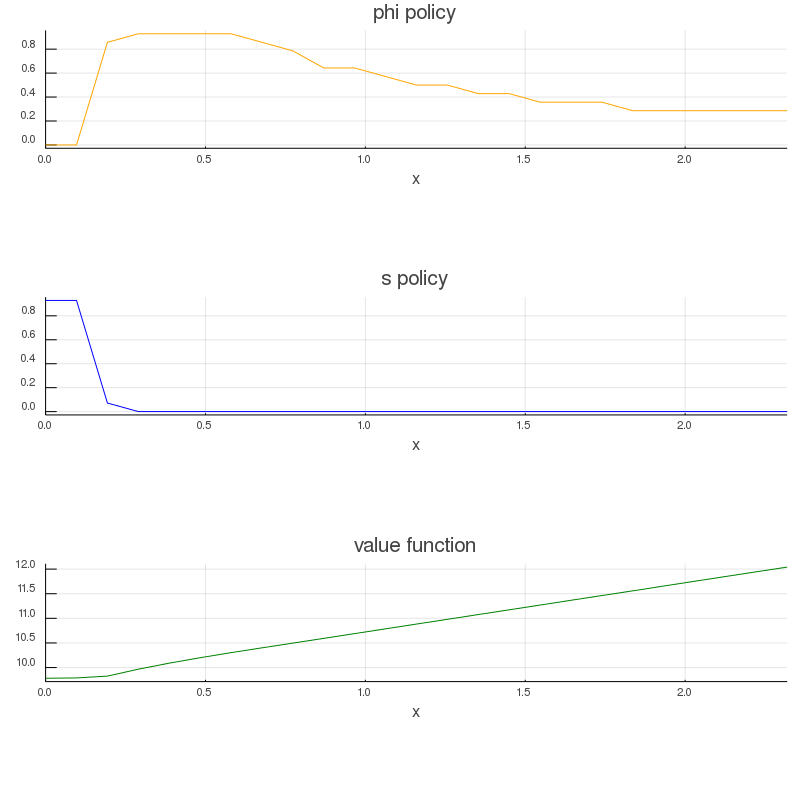

In [4]:
using Plots, NLsolve
gr(fmt=:png);

wp = JvWorker(grid_size=25)
v_init = collect(wp.x_grid) .* 0.5

f(x) = T(wp, x)
V = fixedpoint(f, v_init)
sol_V = V.zero

s_policy, ϕ_policy = T(wp, sol_V, ret_policies = true)

# plot solution
p = plot(wp.x_grid, [ϕ_policy s_policy sol_V],
         title = ["phi policy" "s policy" "value function"],
         color = [:orange :blue :green],
         xaxis = ("x", (0.0, maximum(wp.x_grid))),
         yaxis = ((-0.1, 1.1)), size = (800, 800),
         legend = false, layout = (3, 1),
         bottom_margin = Plots.PlotMeasures.Length(:mm, 20))

The horizontal axis is the state $ x $, while the vertical axis gives $ s(x) $ and $ \phi(x) $.

Overall, the policies match well with our predictions from [section](#jvboecalc).

- Worker switches from one investment strategy to the other depending on relative return.  
- For low values of $ x $, the best option is to search for a new job.  
- Once $ x $ is larger, worker does better by investing in human capital specific to the current position.  

## Exercises


<a id='jv-ex1'></a>

### Exercise 1

Let’s look at the dynamics for the state process $ \{x_t\} $ associated with these policies.

The dynamics are given by [(1)](#equation-jd) when $ \phi_t $ and $ s_t $ are
chosen according to the optimal policies, and $ \mathbb{P}\{b_{t+1} = 1\}
= \pi(s_t) $.

Since the dynamics are random, analysis is a bit subtle.

One way to do it is to plot, for each $ x $ in a relatively fine grid
called `plot_grid`, a
large number $ K $ of realizations of $ x_{t+1} $ given $ x_t =
x $.  Plot this with one dot for each realization, in the form of a 45 degree
diagram.  Set

```julia
K = 50
plot_grid_max, plot_grid_size = 1.2, 100
plot_grid = range(0, plot_grid_max, length = plot_grid_size)
plot(plot_grid, plot_grid, color = :black, linestyle = :dash,
     lims = (0, plot_grid_max), legend = :none)
```


By examining the plot, argue that under the optimal policies, the state
$ x_t $ will converge to a constant value $ \bar x $ close to unity.

Argue that at the steady state, $ s_t \approx 0 $ and $ \phi_t \approx 0.6 $.


<a id='jv-ex2'></a>

### Exercise 2

In the preceding exercise we found that $ s_t $ converges to zero
and $ \phi_t $ converges to about 0.6.

Since these results were calculated at a value of $ \beta $ close to
one, let’s compare them to the best choice for an *infinitely* patient worker.

Intuitively, an infinitely patient worker would like to maximize steady state
wages, which are a function of steady state capital.

You can take it as given—it’s certainly true—that the infinitely patient worker does not
search in the long run (i.e., $ s_t = 0 $ for large $ t $).

Thus, given $ \phi $, steady state capital is the positive fixed point
$ x^*(\phi) $ of the map $ x \mapsto G(x, \phi) $.

Steady state wages can be written as $ w^*(\phi) = x^*(\phi) (1 - \phi) $.

Graph $ w^*(\phi) $ with respect to $ \phi $, and examine the best
choice of $ \phi $.

Can you give a rough interpretation for the value that you see?

## Solutions

### Exercise 1

Here’s code to produce the 45 degree diagram

In [5]:
wp = JvWorker(grid_size=25)
# simplify notation
@unpack G, π_func, F = wp

v_init = collect(wp.x_grid) * 0.5
f2(x) = T(wp, x)
V2 = fixedpoint(f2, v_init)
sol_V2 = V2.zero
s_policy, ϕ_policy = T(wp, sol_V2, ret_policies=true)

# Turn the policy function arrays into CoordInterpGrid objects for interpolation
s = LinearInterpolation(wp.x_grid, s_policy, extrapolation_bc=Line())
ϕ = LinearInterpolation(wp.x_grid, ϕ_policy, extrapolation_bc=Line())

h_func(x, b, U) = (1 - b) * G(x, ϕ(x)) + b * max(G(x, ϕ(x)), U)

h_func (generic function with 1 method)

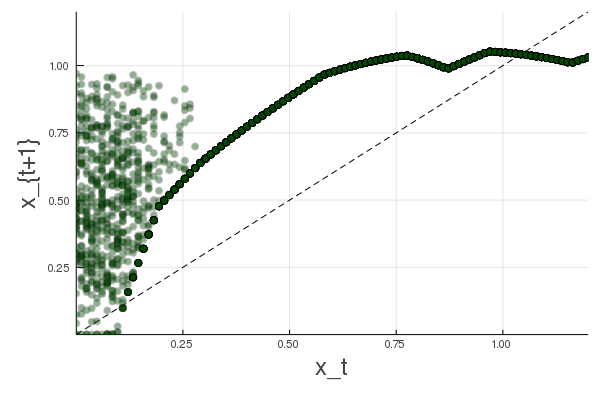

In [6]:
using Random
Random.seed!(42)
K = 50

plot_grid_max, plot_grid_size = 1.2, 100
plot_grid = range(0, plot_grid_max, length = plot_grid_size)
ticks = [0.25, 0.5, 0.75, 1.0]

xs = []
ys = []
for x in plot_grid
    for i=1:K
        b = rand() < π_func(s(x)) ? 1 : 0
        U = rand(wp.F)
        y = h_func(x, b, U)
        push!(xs, x)
        push!(ys, y)
    end
end

plot(plot_grid, plot_grid, color=:black, linestyle=:dash, legend=:none)
scatter!(xs, ys, alpha=0.25, color=:green, lims=(0, plot_grid_max), ticks=ticks)
plot!(xlabel="x_t", ylabel="x_{t+1}", guidefont=font(16))

Looking at the dynamics, we can see that

- If $ x_t $ is below about 0.2 the dynamics are random, but
  $ x_{t+1} > x_t $ is very likely  
- As $ x_t $ increases the dynamics become deterministic, and
  $ x_t $ converges to a steady state value close to 1  


Referring back to the figure here.

[https://julia.quantecon.org/dynamic_programming/jv.html#Solving-for-Policies](https://julia.quantecon.org/dynamic_programming/jv.html#Solving-for-Policies)

we see that $ x_t \approx 1 $ means that
$ s_t = s(x_t) \approx 0 $ and
$ \phi_t = \phi(x_t) \approx 0.6 $.

### Exercise 2

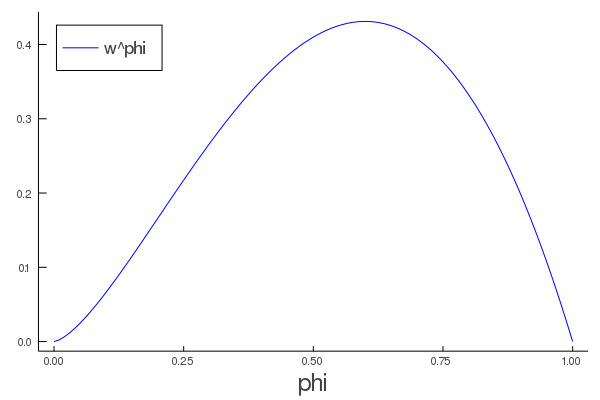

In [7]:
wp = JvWorker(grid_size=25)

xbar(ϕ) = (wp.A * ϕ^wp.α)^(1.0 / (1.0 - wp.α))

ϕ_grid = range(0, 1, length = 100)

plot(ϕ_grid, [xbar(ϕ) * (1 - ϕ) for ϕ in ϕ_grid], color = :blue,
     label = "w^phi", legendfont = font(12), xlabel = "phi",
     guidefont = font(16), grid = false, legend = :topleft)

Observe that the maximizer is around 0.6.

This this is similar to the long run value for $ \phi $ obtained in
exercise 1.

Hence the behaviour of the infinitely patent worker is similar to that
of the worker with $ \beta = 0.96 $.

This seems reasonable, and helps us confirm that our dynamic programming
solutions are probably correct.